# ALL REGRESSIONS

In this version, all plotting will take place separately. We will save data to a csv and then plot from there. In doing so, we will be able save results.

Still need to implement the idea of train/test for linear regression: seeing how well our model works

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make_reg # default is 100 samples, 100 features
from sklearn.datasets import make_classification as Make_class # default is 100 samples, 20 features, 2 classes
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import poisson as pois
def ren(x): return range(len(x))

In [39]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make_reg # default is 100 samples, 100 features
from sklearn.datasets import make_classification as Make_class # default is 100 samples, 20 features, 2 classes
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import poisson as pois
def ren(x): return range(len(x))

class Regression:
    def __init__(self, error, time_limit):
        self.time_limit = time_limit
        self.error = error # epsilon/tolerence
        self.rng = np.random.default_rng()
    
    # Least Squares:
    #____________________________________________________________________________________________
            
    def makeLinearRegressionDataset(self): # make a dataset using sklearn's Make Regression
        dataset = Make_reg(900,1000, noise = 1)
        self.a = dataset[0]
        self.b = dataset[1]
        self.x_copy = self.rng.random(len(self.a[0]))
    
    def importLinearRegressionDataset(self, dataset): # import a regression dataset from sklearn
        dataset = dataset(return_X_y=True)
        self.a = dataset[0]
        self.b = dataset[1]
        self.x_copy = self.rng.random(len(self.a[0]))
        self.L_backup = 10**11
        
    def customLinearRegressionDataset(self, a, b):
        self.a = a
        self.b = b
        self.x_copy = self.rng.random(len(self.a[0]))
        
    def f_Lin(self, X): # linear Regression Function
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g_Lin(self, X): # linearRegressionFunctionGradient
        return self.a.T @ (self.a @ X - self.b)
    def GD_Lin(self): # Linear Regression gradient descent
        self.x = self.x - self.lam*self.grad
    
    def leastSqCheck(self, A, B): # check that x satifies (approx) Ax = b
        self.check = np.allclose(A @ self.x, B)
    
    def Vanilla_Linear_Reg(self, directory): # using a fixed step size of 1/L
        # set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
#         self.L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.L = self.L_backup
        self.lam = 1/self.L # find step size
        self.lamList = [self.lam]
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Lin()
            self.lamList.append(self.lam)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Vanilla_Linear_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
#         self.linCheckList[0] = MSE(self.b, np.dot(self.a, self.x))
        self.LinearVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearVanDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearVanDF.to_csv(directory, index = False)
    
    def Adaptive_Linear_Reg(self, directory): # in which the step size adapts to local curvature
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.lam = 1e-10 # initialise step size > 0
        self.theta = 10**15 # initialise theta = infty
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        
        self.GD_Lin()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Lin(self.x)
        self.gradNorm = np.linalg.norm(self.grad)
        self.lamList.append(self.lam)
        self.gradientValuesList.append(self.gradNorm)
#         self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam) # copy initial step size
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.x - x0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Lin() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Adaptive_Linear_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
#         self.linCheckList[0] = MSE(self.b, np.dot(self.a, self.x))
        self.LinearAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearAdapDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearAdapDF.to_csv(directory, index = False)
    
    def old_LineSearch_Linear_Reg(self, directory): # using a line search
        def BackTrack_1():
            rho = self.rng.random()
            alpha = self.rng.random()
            lam = self.rng.uniform(1,10)
            while self.f_Lin( self.x - lam*self.grad) > self.f_Lin(self.x) - rho*lam*self.gradNorm**2 :
                lam = alpha * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
            
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        BackTrack_1()
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Lin()
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            BackTrack_1()
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("old_LineSearch_Linear_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
#         self.linCheckList[0] = MSE(self.b, np.dot(self.a, self.x))
        self.oldLinearLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearLineSearchDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.oldLinearLineSearchDF.to_csv(directory, index = False)
    
    
    
    
    def Grad_LineSearch_Linear_Reg(self, directory): # using a line search
        def BackTrack():
            start = time.time()
            rho = self.rng.random()
            lam = self.rng.uniform(rho,10)
            while np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) > self.gradNorm:
                lam = rho * lam
#                 if self.time_limit > 0:
                if (time.time() - start) > 30:
                    self.lam = lam
                    return None
            self.lam = lam
            
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        BackTrack()
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Lin()
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            BackTrack()
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Grad_LineSearch_Linear_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
#         self.linCheckList[0] = MSE(self.b, np.dot(self.a, self.x))
        self.LinearLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearLineSearchDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearLineSearchDF.to_csv(directory, index = False)
            
    def Barzilai_Linear_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.lam = self.rng.random() # initialise step size > 0
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        self.GD_Lin()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.lamList.append(self.lam)
        self.gradientValuesList.append(self.gradNorm)
#         self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            nom = np.dot(self.x - x0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / denom            
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Lin() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Barzilai_Linear_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
#         self.linCheckList[0] = MSE(self.b, np.dot(self.a, self.x))
        self.LinearBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.LinearBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Linear_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
#         L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        L = self.L_backup # use L calculated above
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        lam0 = 0
        lam1 = 1
        y0 = deepcopy(self.x)
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam0)/self.lam
            y1 = self.x - self.grad/L
            self.x = (1 - self.gamma)*y1 + self.gamma*y0
            lam0 = deepcopy(lam1)
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Nesterov_Linear_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
#         self.linCheckList[0] = MSE(self.b, np.dot(self.a, self.x))
        self.LinearNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'Accurate': self.linCheckList})
#         self.LinearNestDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearNestDF.to_csv(directory, index = False)
    
    #-------------------------------------------------------------------------------------------
    
    def makeLogisticRegressionDataset(self):
        sample_data = Make_class()
        ones = np.array([[1]*len(sample_data[0])])
        augmented_data = np.concatenate((ones.T, self.normalise(sample_data[0])), axis =1) # add a 1 to the start of each feature
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( augmented_data, sample_data[1], \
                                                                 test_size = 0.1)
        self.weights_copy = self.rng.random( len(self.xTrain[0]) )
        
    def importLogisticRegressionDataset(self, dataset, multi = False):
        if multi == True:
            sample_data = dataset(return_X_y=True, n_class = 2)
        else:
            sample_data = dataset(return_X_y=True)
        ones = np.array([[1]*len(sample_data[0])])
        augmented_data = np.concatenate((ones.T, self.normalise(sample_data[0])), axis =1) # add a 1 to the start of each feature
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( augmented_data, sample_data[1], \
                                                                 test_size = 0.1)
        self.weights_copy = self.rng.random( len(self.xTrain[0]) )
    
    def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
    
    def normalise(self, X): # normalises the input data to values between 0 and 1
        mins = np.min(X, axis = 0) 
        maxs = np.max(X, axis = 0) 
        rng = maxs - mins 
        norm_X = 1 - ((maxs - X)/rng)
        return norm_X
    
    def f_Log(self, W): # function f: the inverse of the log likelihood function, modelling the probability of the data xTrain and xTest
        sig = self.sigmoid(W, self.xTrain)
        step1 = self.yTrain * np.log(sig + 1e-300) # returns an array with log(sig) values where yTrain =1, else 0
        step2 = (1 - self.yTrain) * np.log(1 - sig + 1e-300 )
        final = -step1 - step2 
        return np.mean(final)
    
    def g_Log(self, W): # the gradient function of f, simply (h(w) - y) * x
        sig = self.sigmoid(W, self.xTrain)
        inner_expr = sig - self.yTrain
        return inner_expr.T @ self.xTrain
    
    def GD_Log(self): # Step size calculator - w_1 = w_0 - lam* gradient(w)
        self.weights = self.weights - self.lam * self.grad
        
    def classify(self):
        sig = self.sigmoid(self.weights, self.xTest)
        predict = np.squeeze( np.where( sig >= 0.5, 1, 0 ) )
        self.preds = sum( predict == self.yTest ) / len(self.xTest)
    
    def Vanilla_Logistic_Reg(self, directory):
        self.initialTime= time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make a copy of the weights
        self.lam = 1/np.max(np.linalg.svd( self.xTrain @ self.xTrain.T )[1]) # find step size
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.lamList = [self.lam]
#         self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.lamList.append(self.lam)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Vanilla_Logistic_Reg did not converge")
                    break
        self.LogisticVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accuracy': self.predList})
        self.LogisticVanDF.to_csv(directory, index = False)
    
    def Adaptive_Logistic_Reg(self, directory):
        self.initialTime= time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make a copy of the weights
#         self.lam = 1e-10 # initialise step size > 0
        self.lam = self.rng.random()
        self.theta = 10**15 # initialise theta = infty
        weights0 = deepcopy(self.weights) # make a coopy of weights to preserve previous weights
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        
        self.GD_Log()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
#         self.functionVals.append(self.f_Log(self.weights))
        self.lamList.append(self.lam)
        self.classify()
        self.predList.append(self.preds)
        self.timeList.append(time.time() - self.initialTime)
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.weights - weights0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            weights0 = deepcopy(self.weights) # make a coopy of x to preserve previous x
            self.GD_Log() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.lamList.append(self.lam)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Adaptive_Logistic_Reg did not converge")
                    break
        self.LogisticAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accuracy': self.predList})
        self.LogisticAdapDF.to_csv(directory, index = False)
        
    def old_LineSearch_Logistic_Reg(self, directory): # using a line search
        def BackTrack():
            rho = self.rng.random()
            alpha = self.rng.random()
            lam = self.rng.uniform(1,10) # try using a less stupid number
            while self.f_Log(self.weights- lam*self.grad) > self.f_Log(self.weights) - rho*lam*self.gradNorm**2:
                lam = alpha * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        BackTrack()
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.lamList = [self.lam]
#         self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            BackTrack()
            self.gradientValuesList.append(self.gradNorm)
            self.lamList.append(self.lam)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("oldLineSearch_Logistic_Reg did not converge")
                    break
#             k+=1
        self.oldLogisticLineDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accuracy': self.predList})
        self.oldLogisticLineDF.to_csv(directory, index = False)
        
    def Grad_LineSearch_Logistic_Reg(self, directory): # using a line search
        def BackTrack():
            start = time.time()
            rho = self.rng.random()
            lam = self.rng.uniform(rho,10) # try using a less stupid number
            while np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad) > self.gradNorm:
                lam = rho * lam
#                  if self.time_limit > 0:
                if (time.time() - start) > 30:
                    self.lam = lam
                    return None
            self.lam = lam
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        BackTrack()
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.lamList = [self.lam]
#         self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            BackTrack()
            self.gradientValuesList.append(self.gradNorm)
            self.lamList.append(self.lam)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("GradientLineSearch_Logistic_Reg did not converge")
                    break
#             k+=1
        self.LogisticLineDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accuracy': self.predList})
        self.LogisticLineDF.to_csv(directory, index = False)
    
    def Barzilai_Logistic_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make copies to use
        self.lam = self.rng.random() # initialise step size > 0
        weights0 = deepcopy(self.weights) # make a copy of weughts to preserve previous weights
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.lamList = [self.lam]
#         self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime] # to show time taken
        
        self.GD_Log()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
        self.lamList.append(self.lam)
#         self.functionVals.append(self.f_Log(self.weights))
        self.classify()
        self.predList.append(self.preds)
        self.timeList.append(time.time() - self.initialTime)
        weight_backup = deepcopy(self.weights)
        # loop
        k = 0
        while (self.gradNorm > self.error and k <10):
            nom = np.dot(self.weights - weights0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / (denom +1e-300)           
            weight_backup = deepcopy(self.weights)
            self.GD_Log() # steepest descent
            # we don't update oldGrad in this loop
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.lamList.append(self.lam)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
            k=k+1
        weights0 = weight_backup
        self.oldGrad = self.g_Log(weights0)
        while self.gradNorm > self.error:
            nom = np.dot(self.weights - weights0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / (denom +1e-300)          
            weights0 = deepcopy(self.weights) # make a coopy of x to preserve previous x
            self.GD_Log() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Barzilai_Logistic_Reg did not converge")
                    break
        self.LogisticBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accuracy': self.predList})
        self.LogisticBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Logistic_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        L = np.max(np.linalg.svd( self.xTrain @ self.xTrain.T )[1]) # find L
        self.weights = deepcopy(self.weights_copy) # make copies to use
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        lam0 = 0
        lam1 = 1
        y0 = deepcopy(self.weights)
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam0)/self.lam 
            y1 = self.weights - self.grad/L
            self.weights = (1 - self.gamma)*y1 + self.gamma*y0
            lam0 = deepcopy(lam1)
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Nesterov_Logistic_Reg did not converge")
                    break
        self.LogisticNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'Accuracy': self.predList})
        self.LogisticNestDF.to_csv(directory, index = False)

    #_______________________________________________________________________
    # Poisson Regression
    def makePoissonRegression(self,n,m):
        self.N = n
        self.M = m
        omega = self.rng.random(self.N +1)
        X = self.rng.random((self.M,self.N))
        self.x = np.concatenate((np.ones((self.M,1)),X),axis = 1)
        self.lamb_gen = np.dot(self.x, omega)
        self.y = np.array([pois.rvs(i) for i in self.lamb_gen])
        self.weights_copy = self.rng.random(len(self.x[0]))
    def importPoissonRegression(self, dataset):
        self.N = n
        self.M = m
        omega = self.rng.random(self.N +1)
        X = self.rng.random((self.M,self.N))
        self.x = np.concatenate((np.ones((self.M,1)),X),axis = 1)
        self.lamb_gen = np.dot(self.x, omega)
        self.y = np.array([pois.rvs(i) for i in self.lamb_gen])
        self.weights_copy = self.rng.random(len(self.x[0]))
    def f_Pois(self, W):
        u = self.x @ W
        return np.sum(np.exp(u)) - np.dot(self.y,u)
    def g_Pois(self, W):
        return self.x.T @ np.exp(self.x @ W) - np.dot(self.y, self.x)
    def GD_Pois(self):
        self.weights = self.weights - self.lam*self.grad
        
    def Vanilla_Poisson_Reg(self, directory):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_copy)
        self.lam = 1/np.max(np.linalg.svd( self.x.T @ self.x )[1])
        self.lamList = [self.lam]
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Pois(self.weights)]
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.GD_Pois()
            self.grad = self.g_Pois(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.lamList.append(self.lam)
#             self.functionVals.append(self.f_Pois(self.weights))
            self.timeList.append(time.time() - self.initialTime)
            if self.gradientValuesList[-1] >= self.gradientValuesList[-2]:
                self.weights = deepcopy(self.weights_copy)
                self.lam = 0.1*self.lam
                self.grad = self.g_Pois(self.weights)
                self.gradNorm = np.linalg.norm(self.grad)
                self.gradientValuesList.append(self.gradNorm)
                self.lamList.append(self.lam)
#                 self.functionVals.append(self.f_Pois(self.weights))
                self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Vanilla_Poisson_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.lamb_gen, np.exp(np.dot(self.x, self.weights)))
        self.PoisVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.PoisVanDF.to_csv(directory, index = False)
        
    def Adaptive_Poisson_Reg(self, directory):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_copy)
        self.lam = 1e-10
        self.lamList = [self.lam]
        self.theta = np.inf
        oldWeights = deepcopy(self.weights)
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Pois(self.weights)]
        self.timeList = [time.time() - self.initialTime]
        self.GD_Pois()
        oldGrad = deepcopy(self.grad)
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList.append(self.gradNorm)
        self.lamList.append(self.lam)
#         self.functionVals.append(self.f_Pois(self.weights))
        self.timeList.append(time.time() - self.initialTime)
        while self.gradNorm > self.error:
            oldLam = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.weights - oldWeights) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            self.lamList.append(self.lam)
            oldWeights = deepcopy(self.weights)
            self.GD_Pois()
            self.theta = self.lam/oldLam
            oldGrad = deepcopy(self.grad)
            self.grad = self.g_Pois(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Pois(self.weights))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Adaptive_Poisson_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.lamb_gen, np.exp(np.dot(self.x, self.weights)))
        self.PoisAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.PoisAdapDF.to_csv(directory, index = False)
    
    def oldLineSearch_Poisson_Reg(self,directory):
        def BackTrack():
            def mini_GD(lam): return self.weights - lam*self.grad
            rho = self.rng.random()
            alpha = self.rng.random()
            LAM = self.rng.uniform(1,10)
            while self.f_Pois(mini_GD(LAM)) > self.f_Pois(self.weights) - rho*LAM*self.gradNorm**2:
                LAM = alpha*LAM
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        print("oldLineSearch_Poisson_Reg did not converge")
                        break
            self.lam = LAM
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_copy)
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        BackTrack()
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Pois(self.weights)]
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.GD_Pois()
            self.grad = self.g_Pois(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            BackTrack()
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Pois(self.weights))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("GradientLineSearch_Poisson_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.lamb_gen, np.exp(np.dot(self.x, self.weights)))
        self.oldPoisLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.oldPoisLineSearchDF.to_csv(directory, index = False)
    
    def GradientLineSearch_Poisson_Reg(self,directory):
        def BackTrack():
            start = time.time()
            def mini_GD(lam): return self.weights - lam*self.grad
            rho = self.rng.random()
            LAM = self.rng.uniform(rho,10)
            while np.linalg.norm(self.g_Pois(mini_GD(LAM)) - self.grad) > self.gradNorm:
                LAM = rho*LAM
                #                  if self.time_limit > 0:
                if (time.time() - start) > 30:
                    self.lam = lam
                    return None
            self.lam = LAM
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_copy)
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        BackTrack()
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Pois(self.weights)]
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.GD_Pois()
            self.grad = self.g_Pois(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            BackTrack()
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Pois(self.weights))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("GradientLineSearch_Poisson_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.lamb_gen, np.exp(np.dot(self.x, self.weights)))
        self.PoisLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.PoisLineSearchDF.to_csv(directory, index = False)
        
    def Barzilai_Poisson_Reg(self,directory):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_copy)
        self.lam = 1/np.max(np.linalg.svd( self.x.T @ self.x )[1]*self.M*self.N)
        self.lamList = [self.lam]
        oldWeights = deepcopy(self.weights)
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Pois(self.weights)]
        self.timeList = [time.time() - self.initialTime]
        self.GD_Pois()
        oldGrad = deepcopy(self.grad)
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList.append(self.gradNorm)
        self.lamList.append(self.lam)
#         self.functionVals.append(self.f_Pois(self.weights))
        self.timeList.append(time.time() - self.initialTime)
        while self.gradNorm > self.error:
            nom = np.dot(self.weights - oldWeights, self.grad - oldGrad)
            denom = np.linalg.norm(self.grad - oldGrad)**2
            self.lam = nom / denom # calc new step size
            self.lamList.append(self.lam)
            oldWeights = deepcopy(self.weights)
            self.GD_Pois()
            oldGrad = deepcopy(self.grad)
            self.grad = self.g_Pois(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Pois(self.weights))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Barzilai_Poisson_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.lamb_gen, np.exp(np.dot(self.x, self.weights)))
        self.PoisBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.PoisBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Poisson_Reg(self, directory):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_copy)
        L = np.max(np.linalg.svd( self.x.T @ self.x )[1])
        self.grad = self.g_Pois(self.weights)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Pois(self.weights)]
        self.timeList = [time.time() - self.initialTime]
        lam0 = 0
        lam1 = 1
        y0 = deepcopy(self.weights)
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            gamma = (1 - lam1)/self.lam
            y1 = self.weights - self.grad/L
            self.weights = (1 - gamma)*y1 + gamma*y0
            lam0 = deepcopy(lam1)
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Pois(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Pois(self.weights))
            self.timeList.append(time.time() - self.initialTime)
            if self.gradientValuesList[-1] == self.gradientValuesList[-2]:
                self.weights = deepcopy(self.weights_copy)
                L = L*10
                self.grad = self.g_Pois(self.weights)
                self.gradNorm = np.linalg.norm(self.grad)
                self.gradientValuesList.append(self.gradNorm)
#                 self.functionVals.append(self.f_Pois(self.weights))
                self.timeList.append(time.time() - self.initialTime)
                lam1 = 1
                y0 = deepcopy(self.weights)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Nesterov_Poisson_Reg did not converge")
                    break
#         self.leastSqCheck(self.a, self.b)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.lamb_gen, np.exp(np.dot(self.x, self.weights)))
        self.PoisNesterovDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'Accurate': self.linCheckList})
        self.PoisNesterovDF.to_csv(directory, index = False)
    
    # augment LinReg dataset
    def augmentLinearDataset(self):
        self.A1, self.A2, b1_temp, self.b2 = split(self.a, self.b, test_size = 0.1)
        self.b1 = np.array([i+self.rng.uniform(-10,10) for i in b1_temp])
        self.A2pinv = np.linalg.pinv(self.A2)
    def g_Lin_Constr(self, X): # linearRegressionFunctionGradient
        return self.A1.T @ (self.A1 @ X - self.b1)
    def GD_Constr(self):
        Y = self.x - self.lam*self.grad
        self.x = (Y) - self.A2pinv @ (self.A2 @ (Y) - self.b2)
    
    def Vanilla_Constrained_Reg(self, directory):
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.lam = 1/np.max( np.linalg.svd( self.A1 @ self.A1.T ) [1] ) # find step size
        self.grad = self.g_Lin_Constr(self.x) # calculate gradient
        self.GD_Constr()
        self.grad = self.g_Lin_Constr(self.x) # update gradient
        self.approxGrad = (self.x - self.x_copy)/self.lam
        self.gradNorm = np.linalg.norm(self.approxGrad) # calc the l2 norm of the Approx gradient
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            x0 = deepcopy(self.x)
            self.GD_Constr()
            self.grad = self.g_Lin_Constr(self.x)
            self.approxGrad = (self.x - x0)/self.lam
            self.gradNorm = np.linalg.norm(self.approxGrad)
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Vanilla_Constrained_Reg did not converge")
                    break
#         self.leastSqCheck(self.A1, self.b1)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.b1, np.dot(self.A1, self.x))
#         self.leastSqCheck(self.A2, self.b2)
        self.linCheckList[1] = MSE(self.b2, np.dot(self.A2, self.x))
        self.ConstrVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearVanDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.ConstrVanDF.to_csv(directory, index = False)
    
    def Adaptive_Constrained_Reg(self, directory): # in which the step size adapts to local curvature
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        x0 = deepcopy(self.x_copy)
        self.lam = 1e-10 # initialise step size > 0
        self.theta = np.inf # initialise theta = infty
        self.grad = self.g_Lin_Constr(self.x) # calculate gradient
        self.oldGrad = deepcopy(self.grad)
        self.GD_Constr()
        self.grad = self.g_Lin_Constr(self.x)
        self.approxGrad = (self.x - x0)/self.lam
        self.gradNorm = np.linalg.norm(self.approxGrad)
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm]
#         self.functionVals = [self.f_Lin(self.x)]
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam) # copy initial step size
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.x - x0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Constr() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin_Constr(self.x)
            self.approxGrad = (self.x - x0)/self.lam
            self.gradNorm = np.linalg.norm(self.grad)
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Adaptive_Constrained_Reg did not converge")
                    break
#         self.leastSqCheck(self.A1, self.b1)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.b1, np.dot(self.A1, self.x))
#         self.leastSqCheck(self.A2, self.b2)
        self.linCheckList[1] = MSE(self.b2, np.dot(self.A2, self.x))
        self.ConstrAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearAdapDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.ConstrAdapDF.to_csv(directory, index = False)
    
    def old_LineSearch_Constrained_Reg(self, directory): # using a line search
        def BackTrack():
            temp_gNorm = np.linalg.norm(self.grad)
            rho = self.rng.random()
            alpha = self.rng.random()
            lam = self.rng.uniform(1,10)
            while self.f_Lin( self.x - lam*self.grad) > self.f_Lin(self.x) - rho*lam*temp_gNorm**2 :
                lam = alpha * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
            
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.grad = self.g_Lin_Constr(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # for 1st it. we use grad instead of approxGrad
        BackTrack()
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            x0 = deepcopy(self.x)
            self.GD_Constr()
            self.grad = self.g_Lin_Constr(self.x)
            self.approxGrad = (self.x - x0)/self.lam
            self.gradNorm = np.linalg.norm(self.approxGrad)
            BackTrack()
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Grad_LineSearch_Constrained_Reg did not converge")
                    break
#         self.leastSqCheck(self.A1, self.b1)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.b1, np.dot(self.A1, self.x))
#         self.leastSqCheck(self.A2, self.b2)
        self.linCheckList[1] = MSE(self.b2, np.dot(self.A2, self.x))
        self.ConstrLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearLineSearchDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.ConstrLineSearchDF.to_csv(directory, index = False)
    
    def Grad_LineSearch_Constrained_Reg(self, directory): # using a line search
        def BackTrack():
            start = time.time()
            rho = self.rng.random()
            lam = self.rng.uniform(rho,10)
            while np.linalg.norm(self.g_Lin_Constr(self.x - lam*self.grad) - self.grad) >  self.gradNorm:
                lam = rho * lam
                #                  if self.time_limit > 0:
                if (time.time() - start) > 30:
                    self.lam = lam
                    return None
            self.lam = lam
            
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.grad = self.g_Lin_Constr(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # for 1st it. we use grad instead of approxGrad
        BackTrack()
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            x0 = deepcopy(self.x)
            self.GD_Constr()
            self.grad = self.g_Lin_Constr(self.x)
            self.approxGrad = (self.x - x0)/self.lam
            self.gradNorm = np.linalg.norm(self.approxGrad)
            BackTrack()
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Grad_LineSearch_Constrained_Reg did not converge")
                    break
#         self.leastSqCheck(self.A1, self.b1)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.b1, np.dot(self.A1, self.x))
#         self.leastSqCheck(self.A2, self.b2)
        self.linCheckList[1] = MSE(self.b2, np.dot(self.A2, self.x))
        self.ConstrLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
#         self.LinearLineSearchDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.ConstrLineSearchDF.to_csv(directory, index = False)
            
    def Barzilai_Constrained_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.lam = self.rng.random() # initialise step size > 0
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin_Constr(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.lamList = [self.lam]
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        self.oldGrad = deepcopy(self.grad)
        self.GD_Constr()
        self.grad = self.g_Lin_Constr(self.x) # calculate gradient
        self.approxGrad = (self.x - x0)/self.lam
        self.gradNorm = np.linalg.norm(self.approxGrad) # calc the l2 norm of the gradient
        self.lamList.append(self.lam)
        self.gradientValuesList.append(self.gradNorm)
#         self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            nom = np.dot(self.x - x0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / denom            
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Constr() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin_Constr(self.x)
            self.approxGrad = (self.x - x0)/self.lam
            self.gradNorm = np.linalg.norm(self.approxGrad)
            self.lamList.append(self.lam)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Barzilai_Constrained_Reg did not converge")
                    break
#         self.leastSqCheck(self.A1, self.b1)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.b1, np.dot(self.A1, self.x))
#         self.leastSqCheck(self.A2, self.b2)
        self.linCheckList[1] = MSE(self.b2, np.dot(self.A2, self.x))
        self.ConstrBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'StepSizes': self.lamList, 'Accurate': self.linCheckList})
        self.ConstrBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Constrained_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        L = np.max( np.linalg.svd( self.A1 @ self.A1.T ) [1] )
        self.grad = self.g_Lin_Constr(self.x)
        self.approxGrad = np.linalg.norm(self.grad)
        self.gradientValuesList = [self.approxGrad]
#         self.functionVals = [self.f_Lin(self.x)]
        self.timeList = [time.time() - self.initialTime]
        lam0 = 0
        lam1 = 1
        y0 = deepcopy(self.x)
        z0 = deepcopy(self.x)
        while self.approxGrad > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam0)/self.lam
            self.grad = self.g_Lin_Constr(self.x)
            z1 = self.x - self.grad/L
            y1 = (1 - self.gamma)*z1 + self.gamma*z0
            x0 = deepcopy(self.x)
            self.x = y1 - self.A2pinv @ (self.A2 @ y1 - self.b2)
            lam0 = deepcopy(lam1)
            lam1 = deepcopy(self.lam)
            z0 = deepcopy(z1)
            self.approxGrad = np.linalg.norm(y1 - x0)/(1/L)
            self.gradientValuesList.append(self.approxGrad)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    print("Nesterov_Constrained_Reg did not converge")
                    break
#         self.leastSqCheck(self.A1, self.b1)
        self.linCheckList = [0]*len(self.gradientValuesList)
        self.linCheckList[0] = MSE(self.b1, np.dot(self.A1, self.x))
#         self.leastSqCheck(self.A2, self.b2)
        self.linCheckList[1] = MSE(self.b2, np.dot(self.A2, self.x))
        self.ConstrNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'Accurate': self.linCheckList})
#         self.LinearNestDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.ConstrNestDF.to_csv(directory, index = False)
    
def RunAll(error, runtime, date_time):
    global H
    H = Regression(error, runtime)
    run_lin(date_time)
    print('\n Linear Regression complete')
    run_log(date_time)
    print('\n Logistic Regression complete')
    run_pois(date_time)
    print('\n Poisson Regression complete')
    run_constr(date_time)
    print('\n Constrained Regression complete')    
    read_lin(date_time)
    read_log(date_time)
    read_pois(date_time)
    read_constr(date_time)

def run_lin(date_time):
    H.makeLinearRegressionDataset()
    H.Adaptive_Linear_Reg("output/Lin_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Linear_Reg("output/Lin_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Linear_Reg("output/Lin_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Linear_Reg("output/Lin_Test_Nest_{}.csv".format(date_time))
def read_lin(date_time):
    global Lin_vanilla_out
    Lin_vanilla_out = pd.read_csv("output/Lin_Test_Van_{}.csv".format(date_time))
    global Lin_adap_out
    Lin_adap_out = pd.read_csv("output/Lin_Test_Adap_{}.csv".format(date_time))
    global Lin_line_out
    Lin_line_out = pd.read_csv("output/Lin_Test_LS_{}.csv".format(date_time))
    global Lin_baz_out
    Lin_baz_out = pd.read_csv("output/Lin_Test_Baz_{}.csv".format(date_time))
    global Lin_nest_out
    Lin_nest_out = pd.read_csv("output/Lin_Test_Nest_{}.csv".format(date_time))

def run_log(date_time):
    H.makeLogisticRegressionDataset()
    H.Adaptive_Logistic_Reg("output/Log_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Logistic_Reg("output/Log_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Logistic_Reg("output/Log_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Logistic_Reg("output/Log_Test_Nest_{}.csv".format(date_time))
def read_log(date_time):
    global Log_vanilla_out
    Log_vanilla_out = pd.read_csv("output/Log_Test_Van_{}.csv".format(date_time))
    global Log_adap_out
    Log_adap_out = pd.read_csv("output/Log_Test_Adap_{}.csv".format(date_time))
    global Log_line_out
    Log_line_out = pd.read_csv("output/Log_Test_LS_{}.csv".format(date_time))
    global Log_baz_out
    Log_baz_out = pd.read_csv("output/Log_Test_Baz_{}.csv".format(date_time))
    global Log_nest_out
    Log_nest_out = pd.read_csv("output/Log_Test_Nest_{}.csv".format(date_time))

def run_pois(date_time):
    H.makePoissonRegression(10,int(2e4))
    H.Adaptive_Poisson_Reg("output/Pois_Test_Adap_{}.csv".format(date_time))
    H.GradientLineSearch_Poisson_Reg("output/Pois_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Poisson_Reg("output/Pois_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Poisson_Reg("output/Pois_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Poisson_Reg("output/Pois_Test_Nest_{}.csv".format(date_time))
def read_pois(date_time):
    global Pois_vanilla_out
    Pois_vanilla_out = pd.read_csv("output/Pois_Test_Van_{}.csv".format(date_time))
    global Pois_adap_out
    Pois_adap_out = pd.read_csv("output/Pois_Test_Adap_{}.csv".format(date_time))
    global Pois_line_out
    Pois_line_out = pd.read_csv("output/Pois_Test_LS_{}.csv".format(date_time))
    global Pois_baz_out
    Pois_baz_out = pd.read_csv("output/Pois_Test_Baz_{}.csv".format(date_time))
    global Pois_nest_out
    Pois_nest_out = pd.read_csv("output/Pois_Test_Nest_{}.csv".format(date_time))
    
def run_constr(date_time, Lin_already_Run = True):
    if Lin_already_Run == False:
        H.makeLinearRegressionDataset()
    H.augmentLinearDataset()
    H.Adaptive_Constrained_Reg("output/Constr_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Constrained_Reg("output/Constr_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Constrained_Reg("output/Constr_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Constrained_Reg("output/Constr_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Constrained_Reg("output/Constr_Test_Nest_{}.csv".format(date_time))
def read_constr(date_time):
    global Constr_vanilla_out
    Constr_vanilla_out = pd.read_csv("output/Constr_Test_Van_{}.csv".format(date_time))
    global Constr_adap_out
    Constr_adap_out = pd.read_csv("output/Constr_Test_Adap_{}.csv".format(date_time))
    global Constr_line_out
    Constr_line_out = pd.read_csv("output/Constr_Test_LS_{}.csv".format(date_time))
    global Constr_baz_out
    Constr_baz_out = pd.read_csv("output/Constr_Test_Baz_{}.csv".format(date_time))
    global Constr_nest_out
    Constr_nest_out = pd.read_csv("output/Constr_Test_Nest_{}.csv".format(date_time))

In [2]:
Z = Regression(1e-8, 30)
Z.makeLinearRegressionDataset()
Z.Vanilla_Linear_Reg("L_test_Van.csv")
Z.Adaptive_Linear_Reg("L_test_Adap.csv")
Z.Nesterov_Linear_Reg("L_test_Nest.csv")
nest = pd.read_csv("L_test_Nest.csv")
adap = pd.read_csv("L_test_Adap.csv")

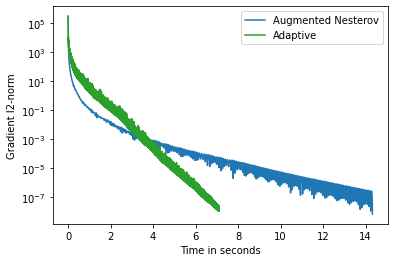

In [4]:
plt.plot(nest.TimeTaken, nest.GradientNorms, c='tab:blue', label='Augmented Nesterov')
plt.plot(adap.TimeTaken, adap.GradientNorms, c='tab:green', label='Adaptive')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.legend()
plt.savefig('L_test_compare.png')

In [56]:
Z = Regression(1e-6, 30)
Z.makeLogisticRegressionDataset()
Z.old_LineSearch_Logistic_Reg("oldlinesearch_test.csv")
Z.Grad_LineSearch_Logistic_Reg("gradlinesearch_test.csv")
grad = pd.read_csv("gradlinesearch_test.csv")
old = pd.read_csv("oldlinesearch_test.csv")

<ipython-input-53-536a14173625>:343: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function


oldLineSearch_Logistic_Reg did not converge
GradientLineSearch_Logistic_Reg did not converge


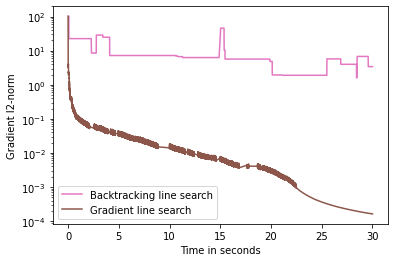

In [58]:
plt.plot(old.TimeTaken, old.GradientNorms, c='tab:pink', label='Backtracking line search')
plt.plot(grad.TimeTaken, grad.GradientNorms, c='tab:brown', label='Gradient line search')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.legend()
plt.savefig('logLinSearch_compare.png')

<ipython-input-126-31612e70c728>:682: RuntimeWarning: overflow encountered in exp
  return np.sum(np.exp(u)) - np.dot(self.y,u)
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


GradientLineSearch_Poisson_Reg did not converge


<ipython-input-126-31612e70c728>:684: RuntimeWarning: overflow encountered in exp
  return self.x.T @ np.exp(self.x @ W) - np.dot(self.y, self.x)


GradientLineSearch_Poisson_Reg did not converge


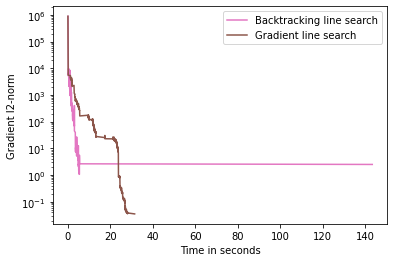

In [129]:
Z = Regression(1e-6, 30)
Z.makePoissonRegression(10, int(2e4))
Z.oldLineSearch_Poisson_Reg("oldlinesearch_test.csv")
Z.GradientLineSearch_Poisson_Reg("gradlinesearch_test.csv")
grad = pd.read_csv("gradlinesearch_test.csv")
old = pd.read_csv("oldlinesearch_test.csv")
plt.plot(old.TimeTaken, old.GradientNorms, c='tab:pink', label='Backtracking line search')
plt.plot(grad.TimeTaken, grad.GradientNorms, c='tab:brown', label='Gradient line search')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.legend()
plt.savefig('poisLinSearch_compare1.png')

Grad_LineSearch_Constrained_Reg did not converge
Grad_LineSearch_Constrained_Reg did not converge


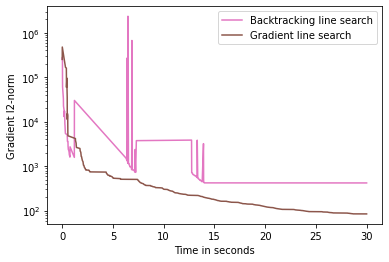

In [138]:
Z = Regression(1e-6, 30)
Z.makeLinearRegressionDataset()
Z.augmentLinearDataset()
Z.old_LineSearch_Constrained_Reg("oldlinesearch_test.csv")
Z.Grad_LineSearch_Constrained_Reg("gradlinesearch_test.csv")
grad = pd.read_csv("gradlinesearch_test.csv")
old = pd.read_csv("oldlinesearch_test.csv")
plt.plot(old.TimeTaken, old.GradientNorms, c='tab:pink', label='Backtracking line search')
plt.plot(grad.TimeTaken, grad.GradientNorms, c='tab:brown', label='Gradient line search')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.legend()
plt.savefig('constrainedLinSearch_compare.png')

In [23]:
Z = Regression(1e-6, 30)
Z.makeLinearRegressionDataset()
Z.old_LineSearch_Linear_Reg("oldlinesearch_test.csv")
Z.Grad_LineSearch_Linear_Reg("gradlinesearch_test.csv")
grad = pd.read_csv("gradlinesearch_test.csv")
old = pd.read_csv("oldlinesearch_test.csv")

KeyboardInterrupt: 

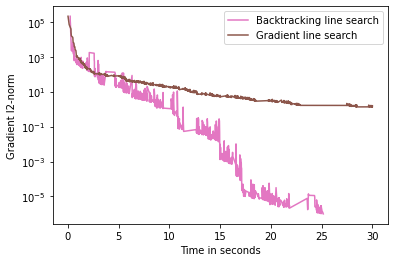

In [60]:
plt.plot(old.TimeTaken, old.GradientNorms, c='tab:pink', label='Backtracking line search')
plt.plot(grad.TimeTaken, grad.GradientNorms, c='tab:brown', label='Gradient line search')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.legend()
plt.savefig('linearLinSearch_compare.png')

Line Search Explore

In [40]:
Z = Regression(1e-6, 0)
Z.makeLinearRegressionDataset()
# Z.old_LineSearch_Linear_Reg("LINoldlinesearch_test.csv")
Z.Grad_LineSearch_Linear_Reg("LINgradlinesearch_test.csv")
LINgrad = pd.read_csv("LINgradlinesearch_test.csv")
# LINold = pd.read_csv("LINoldlinesearch_test.csv")
Z.makeLogisticRegressionDataset()
# Z.old_LineSearch_Logistic_Reg("LOGoldlinesearch_test.csv")
Z.Grad_LineSearch_Logistic_Reg("LOGgradlinesearch_test.csv")
LOGgrad = pd.read_csv("LOGgradlinesearch_test.csv")
# LOGold = pd.read_csv("LOGoldlinesearch_test.csv")
Z.makePoissonRegression(10, int(2e4))
# Z.oldLineSearch_Poisson_Reg("POISoldlinesearch_test.csv")
Z.GradientLineSearch_Poisson_Reg("POISgradlinesearch_test.csv")
POISgrad = pd.read_csv("POISgradlinesearch_test.csv")
# POISold = pd.read_csv("POISoldlinesearch_test.csv")
Z.augmentLinearDataset()
# Z.old_LineSearch_Constrained_Reg("CONoldlinesearch_test.csv")
Z.Grad_LineSearch_Constrained_Reg("CONgradlinesearch_test.csv")
CONgrad = pd.read_csv("CONgradlinesearch_test.csv")
# CONold = pd.read_csv("CONoldlinesearch_test.csv")

<ipython-input-39-c9b7be48aa92>:689: RuntimeWarning: overflow encountered in exp
  return self.x.T @ np.exp(self.x @ W) - np.dot(self.y, self.x)


In [2]:
CONgrad = pd.read_csv("CONgradlinesearch_test.csv")
POISgrad = pd.read_csv("POISgradlinesearch_test.csv")
LOGgrad = pd.read_csv("LOGgradlinesearch_test.csv")
LINgrad = pd.read_csv("LINgradlinesearch_test.csv")

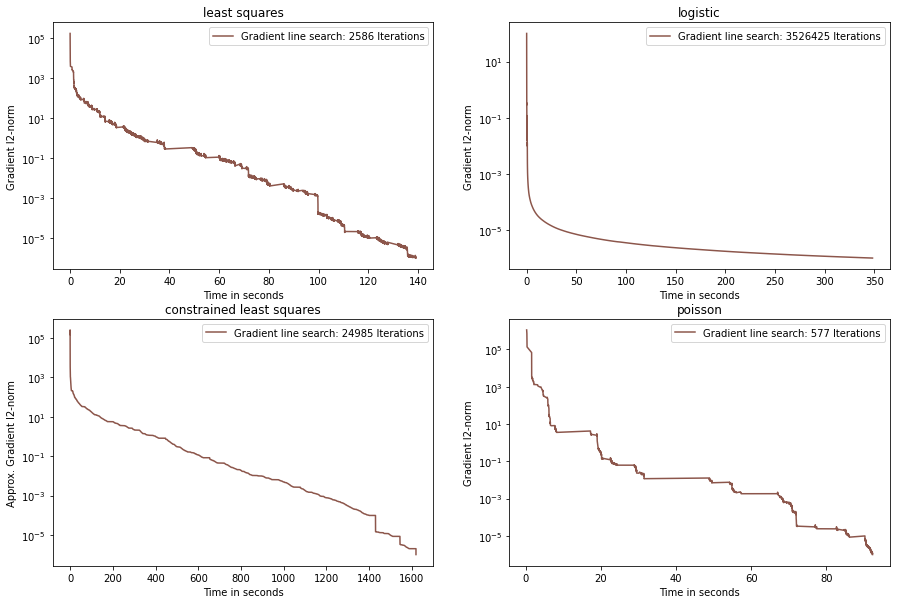

In [3]:
fig, ((a1,a2),(a3,a4)) = plt.subplots(2,2, figsize=(15,10))
# a1.plot(LINold.TimeTaken, LINold.GradientNorms, c='tab:pink', label='Backtracking line search')
a1.plot(LINgrad.TimeTaken, LINgrad.GradientNorms, c='tab:brown', label='Gradient line search: {} Iterations'.format(len(LINgrad.GradientNorms)))
a1.set_yscale('log')
a1.set_xlabel('Time in seconds')
a1.set_ylabel('Gradient l2-norm')
a1.legend()
a1.set_title("least squares")
# a2.plot(LOGold.TimeTaken, LOGold.GradientNorms, c='tab:pink', label='Backtracking line search')
a2.plot(LOGgrad.TimeTaken, LOGgrad.GradientNorms, c='tab:brown', label='Gradient line search: {} Iterations'.format(len(LOGgrad.GradientNorms)))
a2.set_yscale('log')
a2.set_xlabel('Time in seconds')
a2.set_ylabel('Gradient l2-norm')
a2.legend()
a2.set_title("logistic")
# a3.plot(CONold.TimeTaken, CONold.GradientNorms, c='tab:pink', label='Backtracking line search')
a3.plot(CONgrad.TimeTaken, CONgrad.GradientNorms, c='tab:brown', label='Gradient line search: {} Iterations'.format(len(CONgrad.GradientNorms)))
a3.set_yscale('log')
a3.set_xlabel('Time in seconds')
a3.set_ylabel('Approx. Gradient l2-norm')
a3.legend()
a3.set_title("constrained least squares")
# a4.plot(POISold.TimeTaken, POISold.GradientNorms, c='tab:pink', label='Backtracking line search')
a4.plot(POISgrad.TimeTaken, POISgrad.GradientNorms, c='tab:brown', label='Gradient line search: {} Iterations'.format(len(POISgrad.GradientNorms)))
a4.set_yscale('log')
a4.set_xlabel('Time in seconds')
a4.set_ylabel('Gradient l2-norm')
a4.legend()
a4.set_title("poisson")
fig.savefig("LS_compare2.png")

In [7]:
read_log("05.10.11.33")

In [7]:
RunAll(1e-6,20,"05.10.11.33")

Grad_LineSearch_Linear_Reg did not converge

 Linear Regression complete


<ipython-input-6-3d5f93c0254d>:436: RuntimeWarning: divide by zero encountered in double_scalars
  self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
<ipython-input-6-3d5f93c0254d>:345: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function


GradientLineSearch_Logistic_Reg did not converge
Vanilla_Logistic_Reg did not converge

 Logistic Regression complete


<ipython-input-6-3d5f93c0254d>:673: RuntimeWarning: overflow encountered in exp
  return self.x.T @ np.exp(self.x @ W) - np.dot(self.y, self.x)


GradientLineSearch_Poisson_Reg did not converge

 Poisson Regression complete
Grad_LineSearch_Constrained_Reg did not converge

 Constrained Regression complete


# Linear Regression Output

Full plot

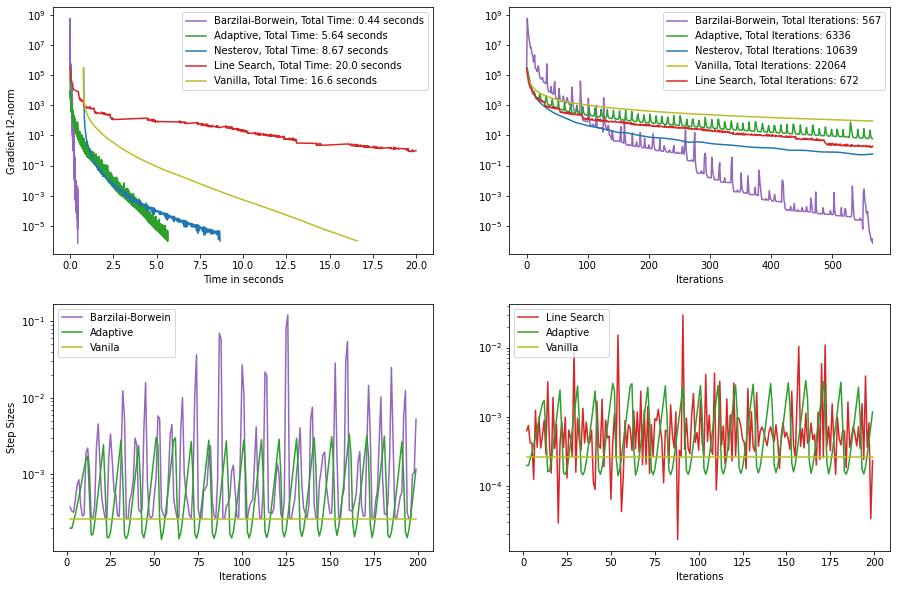

In [25]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Lin_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Lin_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Lin_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Lin_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Lin_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Gradient l2-norm')
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Lin_baz_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_adap_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Lin_adap_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_nest_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Lin_nest_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_vanilla_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Lin_vanilla_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_line_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Lin_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,200), Lin_baz_out.StepSizes[2:200],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,200), Lin_adap_out.StepSizes[2:200],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,200), Lin_vanilla_out.StepSizes[2:200],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,200), Lin_line_out.StepSizes[2:200],c = 'tab:red', label = 'Line Search')
# ax4.plot(range(2,len(Lin_baz_out.StepSizes)), Lin_baz_out.StepSizes[2:],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,200), Lin_adap_out.StepSizes[2:200],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,200), Lin_vanilla_out.StepSizes[2:200],c = 'tab:olive', label = 'Vanilla')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("lin_reg.png")

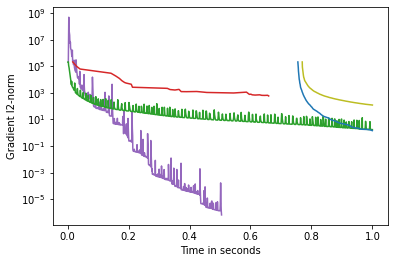

In [79]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Lin_baz_out.TimeTaken.iloc[-1],2)))
plt.plot(Lin_adap_out.TimeTaken[:np.where(Lin_adap_out.TimeTaken > 1)[0][0]], Lin_adap_out.GradientNorms[:np.where(Lin_adap_out.TimeTaken > 1)[0][0]], c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Lin_adap_out.TimeTaken.iloc[-1],2)))
plt.plot(Lin_nest_out.TimeTaken[:np.where(Lin_nest_out.TimeTaken > 1)[0][0]], Lin_nest_out.GradientNorms[:np.where(Lin_nest_out.TimeTaken > 1)[0][0]], c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Lin_nest_out.TimeTaken.iloc[-1],2)))
plt.plot(Lin_line_out.TimeTaken[:np.where(Lin_line_out.TimeTaken > 1)[0][0]], Lin_line_out.GradientNorms[:np.where(Lin_line_out.TimeTaken > 1)[0][0]], c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Lin_line_out.TimeTaken.iloc[-1],2)))
plt.plot(Lin_vanilla_out.TimeTaken[:np.where(Lin_vanilla_out.TimeTaken > 1)[0][0]], Lin_vanilla_out.GradientNorms[:np.where(Lin_vanilla_out.TimeTaken > 1)[0][0]], c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Lin_vanilla_out.TimeTaken.iloc[-1],2)))
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.savefig('L_calc_fig.png')

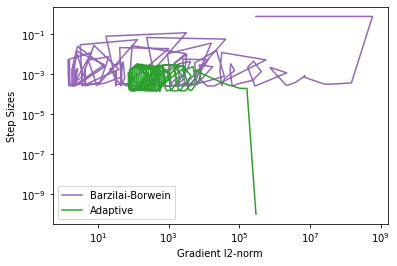

In [34]:
plt.plot(Lin_baz_out.GradientNorms[:200], Lin_baz_out.StepSizes[:200], c = 'tab:purple', label = 'Barzilai-Borwein')
plt.plot(Lin_adap_out.GradientNorms[:200], Lin_adap_out.StepSizes[:200], c = 'tab:green', label = 'Adaptive')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Gradient l2-norm')
plt.ylabel('Step Sizes')
plt.legend()
plt.savefig('adap_v_baz_grad_v_step.png')

In [76]:
Lin_adap_out.TimeTaken[np.where(Lin_adap_out.TimeTaken > 1)[0][0]]

1.0009303092956543

In [8]:
print("Van tail", Lin_vanilla_out.tail())
print("Adap tail", Lin_adap_out.tail())
print("LS tail", Lin_line_out.tail())
print("Baz tail", Lin_baz_out.tail())
print("Nest tail", Lin_nest_out.tail())

Van tail        GradientNorms  TimeTaken  StepSizes  Accurate
22059   1.002449e-06  16.596671   0.000262       0.0
22060   1.001766e-06  16.597663   0.000262       0.0
22061   1.001083e-06  16.598655   0.000262       0.0
22062   1.000401e-06  16.599646   0.000262       0.0
22063   9.997196e-07  16.600639   0.000262       0.0
Adap tail       GradientNorms  TimeTaken  StepSizes  Accurate
6331   2.428388e-06   5.634704   0.000137       0.0
6332   1.470624e-06   5.635696   0.000135       0.0
6333   1.107348e-06   5.637184   0.000144       0.0
6334   1.004121e-06   5.638176   0.000179       0.0
6335   9.904826e-07   5.638672   0.000268       0.0
LS tail      GradientNorms  TimeTaken  StepSizes  Accurate
667       0.931528  19.577322   0.000191       0.0
668       0.855662  19.781674   0.002131       0.0
669       1.119437  19.801019   0.000331       0.0
670       0.863065  19.809947   0.000949       0.0
671       0.981059  20.000410   0.000949       0.0
Baz tail      GradientNorms  TimeTake

# Logistic Regression output

In [26]:
read_log("05.10.11.33")

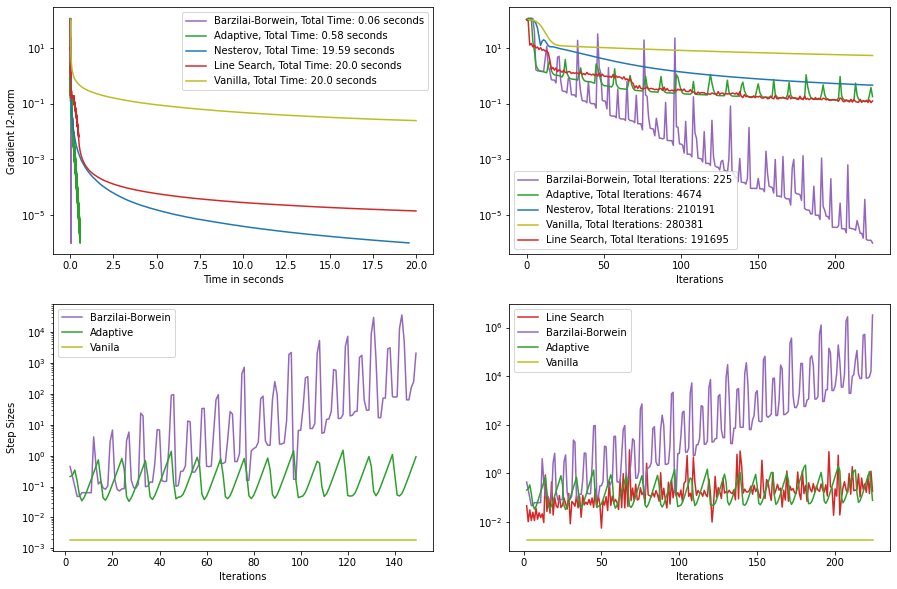

In [27]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Log_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Log_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_nest_out.TimeTaken, Log_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Log_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_line_out.TimeTaken, Log_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Log_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_vanilla_out.TimeTaken, Log_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Log_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Gradient l2-norm')
ax2.plot(ren(Log_baz_out.GradientNorms), Log_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Log_baz_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_adap_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Log_adap_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_nest_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Log_nest_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_vanilla_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Log_vanilla_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_line_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Log_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,150), Log_baz_out.StepSizes[2:150],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,150), Log_adap_out.StepSizes[2:150],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,150), Log_vanilla_out.StepSizes[2:150],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,len(Log_baz_out.StepSizes)), Log_line_out.StepSizes[2:len(Log_baz_out.StepSizes)],c = 'tab:red', label = 'Line Search')
ax4.plot(range(2,len(Log_baz_out.StepSizes)), Log_baz_out.StepSizes[2:],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,len(Log_baz_out.StepSizes)), Log_adap_out.StepSizes[2:len(Log_baz_out.StepSizes)],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,len(Log_baz_out.StepSizes)), Log_vanilla_out.StepSizes[2:len(Log_baz_out.StepSizes)],c = 'tab:olive', label = 'Vanilla')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("log_reg.png")

In [17]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final         GradientNorms  TimeTaken  StepSizes  Accuracy
280376       0.024487  19.999780   0.001919       0.8
280377       0.024487  19.999780   0.001919       0.8
280378       0.024487  19.999780   0.001919       0.8
280379       0.024487  19.999780   0.001919       0.8
280380       0.024487  20.000276   0.001919       0.8
Adap final       GradientNorms  TimeTaken     StepSizes  Accuracy
4669   1.016608e-06   0.580369   7906.143367       0.7
4670   1.004508e-06   0.580369  11993.898349       0.7
4671   1.003135e-06   0.580863  19028.520150       0.7
4672   1.000980e-06   0.580863  30602.905324       0.7
4673   9.978190e-07   0.580863  49424.072258       0.7
LS final         GradientNorms  TimeTaken  StepSizes  Accuracy
191690       0.000014  19.999777   8.058781       0.8
191691       0.000014  19.999777   6.892711       0.8
191692       0.000014  19.999777   8.758237       0.8
191693       0.000014  19.999777   9.767128       0.8
191694       0.000014  20.000271   9.135114   

# Poisson Regression output

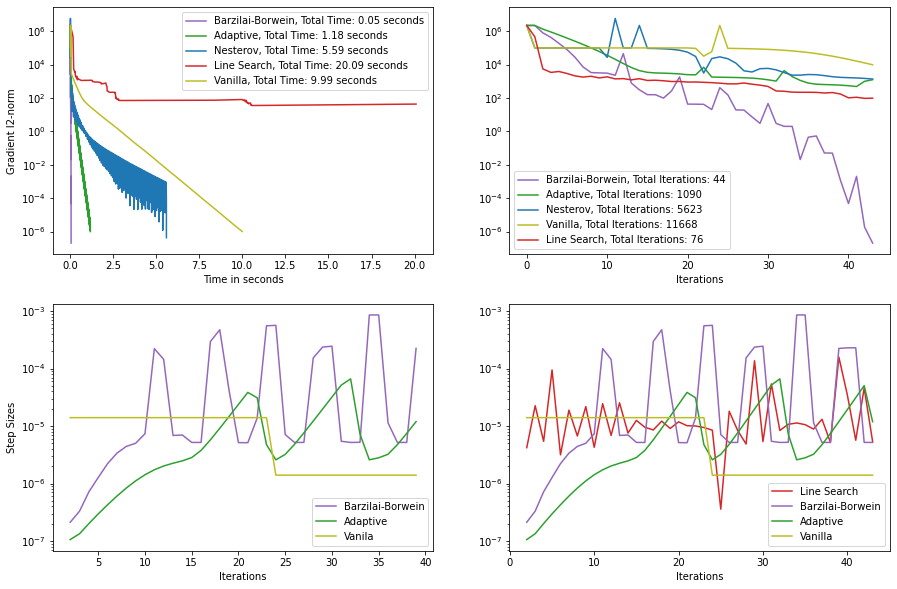

In [15]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Pois_baz_out.TimeTaken, Pois_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Pois_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Pois_adap_out.TimeTaken, Pois_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Pois_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Pois_nest_out.TimeTaken, Pois_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Pois_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Pois_line_out.TimeTaken, Pois_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Pois_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Pois_vanilla_out.TimeTaken, Pois_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Pois_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Gradient l2-norm')
ax2.plot(ren(Pois_baz_out.GradientNorms), Pois_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Pois_baz_out.GradientNorms)))
ax2.plot(ren(Pois_baz_out.GradientNorms), Pois_adap_out.GradientNorms[:len(Pois_baz_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Pois_adap_out.GradientNorms)))
ax2.plot(ren(Pois_baz_out.GradientNorms), Pois_nest_out.GradientNorms[:len(Pois_baz_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Pois_nest_out.GradientNorms)))
ax2.plot(ren(Pois_baz_out.GradientNorms), Pois_vanilla_out.GradientNorms[:len(Pois_baz_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Pois_vanilla_out.GradientNorms)))
ax2.plot(ren(Pois_baz_out.GradientNorms), Pois_line_out.GradientNorms[:len(Pois_baz_out.GradientNorms)], c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Pois_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,40), Pois_baz_out.StepSizes[2:40],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,40), Pois_adap_out.StepSizes[2:40],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,40), Pois_vanilla_out.StepSizes[2:40],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,len(Pois_baz_out.StepSizes)), Pois_line_out.StepSizes[2:len(Pois_baz_out.StepSizes)],c = 'tab:red', label = 'Line Search')
ax4.plot(range(2,len(Pois_baz_out.StepSizes)), Pois_baz_out.StepSizes[2:],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,len(Pois_baz_out.StepSizes)), Pois_adap_out.StepSizes[2:len(Pois_baz_out.StepSizes)],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,len(Pois_baz_out.StepSizes)), Pois_vanilla_out.StepSizes[2:len(Pois_baz_out.StepSizes)],c = 'tab:olive', label = 'Vanilla')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("pois_reg1.png")

In [20]:
print("Van tail", Pois_vanilla_out.tail())
print("Adap tail", Pois_adap_out.tail())
print("LS tail", Pois_line_out.tail())
print("Baz tail", Pois_baz_out.tail())
print("Nest tail", Pois_nest_out.tail())

Van tail        GradientNorms  TimeTaken  StepSizes  Accurate
10876   1.006283e-06   8.864024   0.000001       0.0
10877   1.004594e-06   8.865015   0.000001       0.0
10878   1.002892e-06   8.865511   0.000001       0.0
10879   1.001250e-06   8.866999   0.000001       0.0
10880   9.995616e-07   8.867496   0.000001       0.0
Adap tail      GradientNorms  TimeTaken  StepSizes  Accurate
990   1.071366e-06   1.121516   0.000003       0.0
991   1.040050e-06   1.122516   0.000005       0.0
992   1.030629e-06   1.123997   0.000008       0.0
993   1.015743e-06   1.125101   0.000012       0.0
994   9.922607e-07   1.126097   0.000019       0.0
LS tail      GradientNorms  TimeTaken  StepSizes  Accurate
312       0.020627  19.461465   0.000125       0.0
313       0.026175  19.481302   0.000003       0.0
314       0.019066  19.970359   0.000012       0.0
315       0.020572  19.989208   0.000007       0.0
316       0.017692  24.490410   0.000019       0.0
Baz tail     GradientNorms  TimeTaken  Step

# Constrained Linear Regression Output

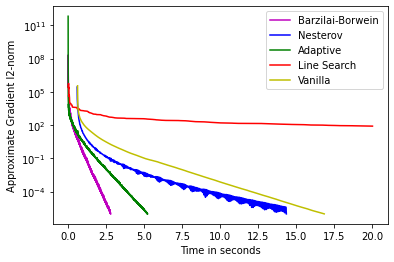

In [13]:
plt.plot(Constr_baz_out.TimeTaken, Constr_baz_out.GradientNorms, c = 'm', label = 'Barzilai-Borwein')
plt.plot(Constr_nest_out.TimeTaken, Constr_nest_out.GradientNorms, c = 'b', label = 'Nesterov')
plt.plot(Constr_adap_out.TimeTaken, Constr_adap_out.GradientNorms, c = 'g', label = 'Adaptive')
plt.plot(Constr_line_out.TimeTaken, Constr_line_out.GradientNorms, c = 'r', label = 'Line Search')
plt.plot(Constr_vanilla_out.TimeTaken, Constr_vanilla_out.GradientNorms, c = 'y', label = 'Vanilla')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Approximate Gradient l2-norm')
plt.legend()
plt.show()

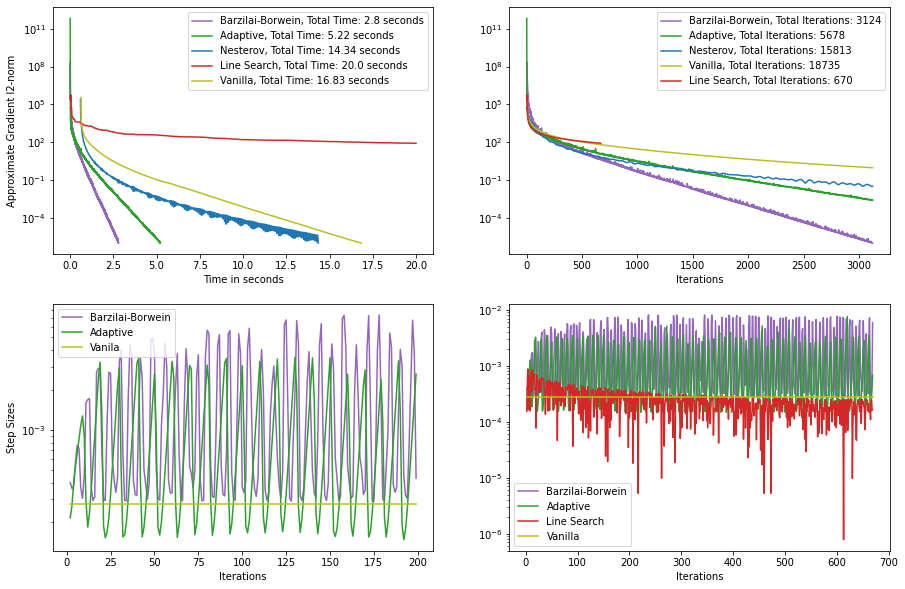

In [14]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Constr_baz_out.TimeTaken, Constr_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Constr_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Constr_adap_out.TimeTaken, Constr_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Constr_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Constr_nest_out.TimeTaken, Constr_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Constr_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Constr_line_out.TimeTaken, Constr_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Constr_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Constr_vanilla_out.TimeTaken, Constr_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Constr_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Approximate Gradient l2-norm')
ax2.plot(ren(Constr_baz_out.GradientNorms), Constr_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Constr_baz_out.GradientNorms)))
ax2.plot(ren(Constr_baz_out.GradientNorms), Constr_adap_out.GradientNorms[:len(Constr_baz_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Constr_adap_out.GradientNorms)))
ax2.plot(ren(Constr_baz_out.GradientNorms), Constr_nest_out.GradientNorms[:len(Constr_baz_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Constr_nest_out.GradientNorms)))
ax2.plot(ren(Constr_baz_out.GradientNorms), Constr_vanilla_out.GradientNorms[:len(Constr_baz_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Constr_vanilla_out.GradientNorms)))
ax2.plot(ren(Constr_line_out.GradientNorms), Constr_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Constr_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,200), Constr_baz_out.StepSizes[2:200],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,200), Constr_adap_out.StepSizes[2:200],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,200), Constr_vanilla_out.StepSizes[2:200],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,len(Constr_line_out.StepSizes)), Constr_baz_out.StepSizes[2:len(Constr_line_out.StepSizes)],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,len(Constr_line_out.StepSizes)), Constr_adap_out.StepSizes[2:len(Constr_line_out.StepSizes)],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,len(Constr_line_out.StepSizes)), Constr_line_out.StepSizes[2:],c = 'tab:red', label = 'Line Search')
ax4.plot(range(2,len(Constr_line_out.StepSizes)), Constr_vanilla_out.StepSizes[2:len(Constr_line_out.StepSizes)],c = 'tab:olive', label = 'Vanilla')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("constr_reg.png")

In [24]:
print("\n Vanilla accurate:", Constr_vanilla_out.Accurate[0])
print("\n Vanilla constraint met:", Constr_vanilla_out.Accurate[1])
print("\n Adaptive accurate:", Constr_adap_out.Accurate[0])
print("\n Adaptive constraint met:", Constr_adap_out.Accurate[1])
print("\n Line Search accurate:", Constr_line_out.Accurate[0])
print("\n Line Search constraint met:", Constr_line_out.Accurate[1])
print("\n Barzilai accurate:", Constr_baz_out.Accurate[0])
print("\n Barzilai constraint met:", Constr_baz_out.Accurate[1])
print("\n Nesterov accurate:", Constr_nest_out.Accurate[0])
print("\n Nesterov constraint met:", Constr_nest_out.Accurate[1])


 Vanilla accurate: 3.426931165881986e-16

 Vanilla constraint met: 3.51100738973238e-26

 Adaptive accurate: 1.1018373887750994e-17

 Adaptive constraint met: 3.243456393823497e-26

 Line Search accurate: 3.777492762256556

 Line Search constraint met: 3.746066464941377e-26

 Barzilai accurate: 3.368056283348544e-16

 Barzilai constraint met: 5.705042285686386e-26

 Nesterov accurate: 1.0482659244711038e-17

 Nesterov constraint met: 6.665963395969387e-26


In [25]:
print("Van final", Constr_vanilla_out.tail())
print("Adap final", Constr_adap_out.tail())
print("LS final", Constr_line_out.tail())
print("Baz final", Constr_baz_out.tail())
print("Nest final", Constr_nest_out.tail())

Van final        GradientNorms  TimeTaken  StepSizes  Accurate
17427   1.003430e-06  14.925797   0.000279       0.0
17428   1.002424e-06  14.926293   0.000279       0.0
17429   1.001418e-06  14.927284   0.000279       0.0
17430   1.000416e-06  14.928277   0.000279       0.0
17431   9.994172e-07  14.928773   0.000279       0.0
Adap final       GradientNorms  TimeTaken  StepSizes  Accurate
5261   1.005943e-06   6.040295   0.002240       0.0
5262   1.114763e-06   6.041285   0.002760       0.0
5263   1.028164e-06   6.042773   0.000457       0.0
5264   1.000179e-06   6.044262   0.000159       0.0
5265   9.922918e-07   6.045749   0.000182       0.0
LS final      GradientNorms  TimeTaken  StepSizes  Accurate
118     257.997253  11.368826   0.000338       0.0
119     255.913095  11.403546   0.000295       0.0
120     253.145670  11.430826   0.000270       0.0
121     250.775052  11.437770   0.000217       0.0
122     248.634482  20.000225   0.000217       0.0
Baz final       GradientNorms  Tim

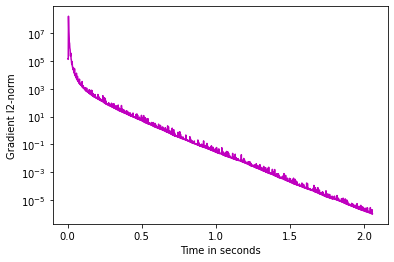

In [26]:
plt.plot(Constr_baz_out.TimeTaken, Constr_baz_out.GradientNorms, c = 'm', )
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.show()

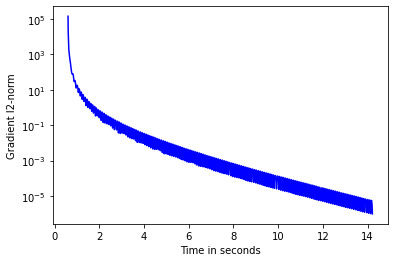

In [27]:
plt.plot(Constr_nest_out.TimeTaken, Constr_nest_out.GradientNorms, c = 'b')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.ylabel('Gradient l2-norm')
plt.show()

# Real data

We'll look at two datasets for each type (initally):

Linear Regression:
- Diabetes https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes
- Boston Housing: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

Logistic Regression:
- Digits https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
- Breast Cancer https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

## Diabetes

In [2]:
from sklearn.datasets import load_diabetes as diabetes

In [13]:
diabetes()

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [7]:
!pip install tabulate

You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python38-32\python.exe -m pip install --upgrade pip' command.


In [8]:
from tabulate import tabulate

In [12]:
print(tabulate(diabetes(return_X_y=True)[0][0:3],tablefmt="latex", floatfmt=".3f"))

\begin{tabular}{rrrrrrrrrr}
\hline
  0.038 &  0.051 &  0.062 &  0.022 & -0.044 & -0.035 & -0.043 & -0.003 &  0.020 & -0.018 \\
 -0.002 & -0.045 & -0.051 & -0.026 & -0.008 & -0.019 &  0.074 & -0.039 & -0.068 & -0.092 \\
  0.085 &  0.051 &  0.044 & -0.006 & -0.046 & -0.034 & -0.032 & -0.003 &  0.003 & -0.026 \\
\hline
\end{tabular}


In [ ]:
for 

In [98]:
np.shape(diabetes(return_X_y=True)[0])

(442, 10)

In [68]:
H = Regression(1e-6, 10)
H.importLinearRegressionDataset(diabetes)
H.Adaptive_Linear_Reg("output/Lin_Test_Adap_diabetes1.csv")
H.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_diabetes1.csv".format(diabetes))
H.Vanilla_Linear_Reg("output/Lin_Test_Van_diabetes1.csv".format(diabetes))
H.Barzilai_Linear_Reg("output/Lin_Test_Baz_diabetes1.csv".format(diabetes))
H.Nesterov_Linear_Reg("output/Lin_Test_Nest_diabetes1.csv".format(diabetes))

<ipython-input-6-3d5f93c0254d>:260: RuntimeWarning: invalid value encountered in double_scalars
  self.lam = nom / denom


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
read_lin("diabetes1")

In [63]:
print("Van final", Lin_vanilla_out.head())
print("Adap final", Lin_adap_out.head())
print("LS final", Lin_line_out.head())
print("Baz final", Lin_baz_out.head())
print("Nest final", Lin_nest_out.head())

Van final    GradientNorms  TimeTaken  StepSizes      Accurate
0    1952.079871   0.142838   0.248496  26004.287402
1     547.937664   0.142838   0.248496      0.000000
2     403.065445   0.142838   0.248496      0.000000
3     300.239340   0.142838   0.248496      0.000000
4     226.160788   0.142838   0.248496      0.000000
Adap final    GradientNorms  TimeTaken     StepSizes      Accurate
0    1952.079871   0.000000  1.000000e-10  26004.287402
1    1952.079870   0.000497  1.000000e-10      0.000000
2    1050.646051   0.000497  1.337979e-01      0.000000
3     669.815817   0.000497  1.337979e-01      0.000000
4     481.572434   0.000497  1.535751e-01      0.000000
LS final    GradientNorms  TimeTaken  StepSizes      Accurate
0    1952.079871   0.000505   0.042533  26004.287402
1    1656.382910   0.000978   0.162085      0.000000
2     786.250124   0.000978   0.294907      0.000000
3     415.282986   0.000978   0.011094      0.000000
4     409.773694   0.000978   0.534159      0.00000

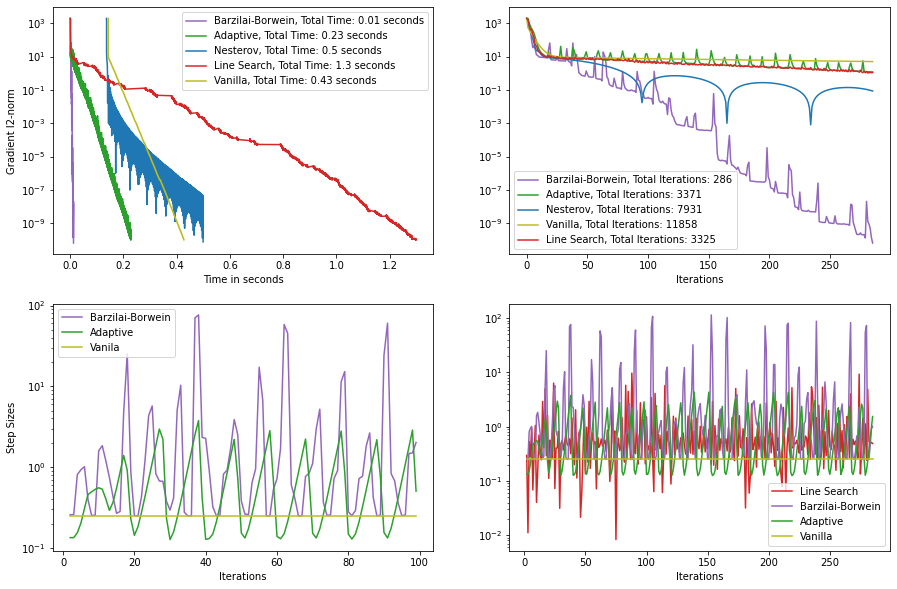

In [66]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Lin_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Lin_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Lin_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Lin_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Lin_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Gradient l2-norm')
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Lin_baz_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_adap_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Lin_adap_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_nest_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Lin_nest_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_vanilla_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Lin_vanilla_out.GradientNorms)))
ax2.plot(ren(Lin_baz_out.GradientNorms), Lin_line_out.GradientNorms[:len(Lin_baz_out.GradientNorms)], c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Lin_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,100), Lin_baz_out.StepSizes[2:100],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,100), Lin_adap_out.StepSizes[2:100],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,100), Lin_vanilla_out.StepSizes[2:100],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,len(Lin_baz_out.StepSizes)), Lin_line_out.StepSizes[2:len(Lin_baz_out.StepSizes)],c = 'tab:red', label = 'Line Search')
ax4.plot(range(2,len(Lin_baz_out.StepSizes)), Lin_baz_out.StepSizes[2:],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,len(Lin_baz_out.StepSizes)), Lin_adap_out.StepSizes[2:len(Lin_baz_out.StepSizes)],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,len(Lin_baz_out.StepSizes)), Lin_vanilla_out.StepSizes[2:len(Lin_baz_out.StepSizes)],c = 'tab:olive', label = 'Vanilla')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("lin_reg_diabetes1.png")

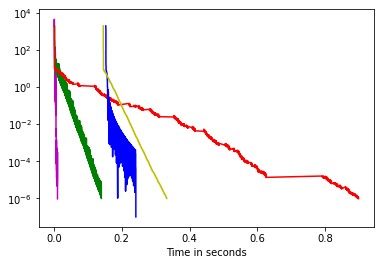

In [33]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## California Housing for least squares

In [14]:
from sklearn.datasets import fetch_california_housing as california

In [23]:
california()

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [22]:
print(tabulate(california(return_X_y=True)[0][0:3],tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrrrrrr}
\hline
 8.33 & 41.00 & 6.98 & 1.02 &  322.00 & 2.56 & 37.88 & -122.23 \\
 8.30 & 21.00 & 6.24 & 0.97 & 2401.00 & 2.11 & 37.86 & -122.22 \\
 7.26 & 52.00 & 8.29 & 1.07 &  496.00 & 2.80 & 37.85 & -122.24 \\
\hline
\end{tabular}


In [3]:
H = Regression(1e-6, 20)
H.importLinearRegressionDataset(california)
H.Vanilla_Linear_Reg("output/Lin_Test_Van_california1.csv".format(california))
H.Adaptive_Linear_Reg("output/Lin_Test_Adap_california1.csv")
H.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_california1.csv".format(california))
H.Barzilai_Linear_Reg("output/Lin_Test_Baz_california1.csv".format(california))
H.Nesterov_Linear_Reg("output/Lin_Test_Nest_california1.csv".format(california))

Vanilla_Linear_Reg did not converge
Adaptive_Linear_Reg did not converge
Grad_LineSearch_Linear_Reg did not converge


<ipython-input-1-72431bfdd750>:262: RuntimeWarning: invalid value encountered in double_scalars
  self.lam = nom / denom


Nesterov_Linear_Reg did not converge


In [2]:
read_lin("california1")

In [3]:
np.min(Lin_baz_out.StepSizes[2"])

-1.2708394398605218e-07

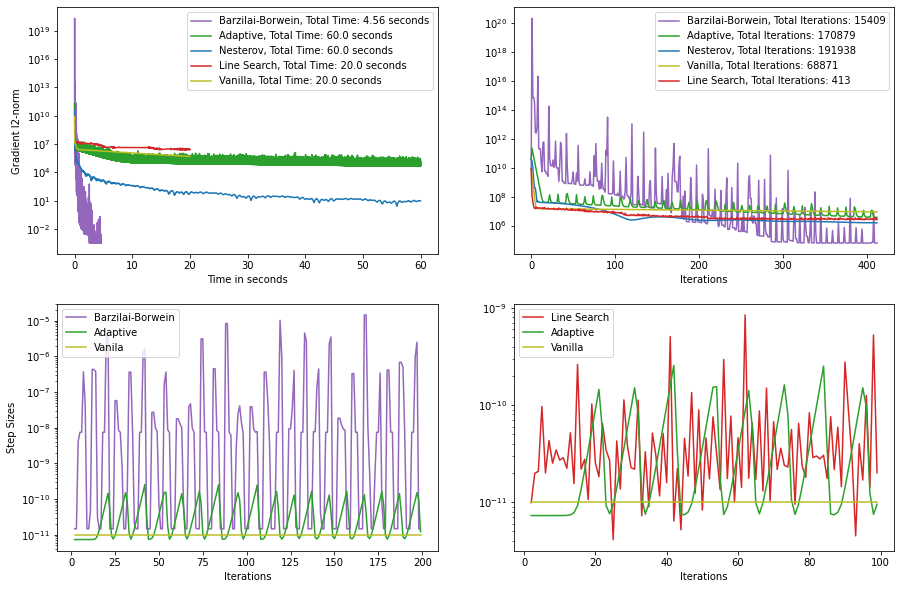

In [4]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Lin_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Lin_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Lin_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Lin_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Lin_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Gradient l2-norm')
ax2.plot(ren(Lin_line_out.GradientNorms), Lin_baz_out.GradientNorms[:len(Lin_line_out.GradientNorms)], c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Lin_baz_out.GradientNorms)))
ax2.plot(ren(Lin_line_out.GradientNorms), Lin_adap_out.GradientNorms[:len(Lin_line_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Lin_adap_out.GradientNorms)))
ax2.plot(ren(Lin_line_out.GradientNorms), Lin_nest_out.GradientNorms[:len(Lin_line_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Lin_nest_out.GradientNorms)))
ax2.plot(ren(Lin_line_out.GradientNorms), Lin_vanilla_out.GradientNorms[:len(Lin_line_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Lin_vanilla_out.GradientNorms)))
ax2.plot(ren(Lin_line_out.GradientNorms), Lin_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Lin_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,200), Lin_baz_out.StepSizes[2:200],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,200), Lin_adap_out.StepSizes[2:200],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,200), Lin_vanilla_out.StepSizes[2:200],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,100), Lin_line_out[2:100].StepSizes,c = 'tab:red', label = 'Line Search')
# ax4.plot(range(2,100), Lin_baz_out.StepSizes[2:100],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,100), Lin_adap_out.StepSizes[2:100],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,100), Lin_vanilla_out.StepSizes[2:100],c = 'tab:olive', label = 'Vanilla')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("lin_reg_california_house2.png")

In [8]:
H = Regression(1e-3, 60)
H.importLinearRegressionDataset(california)
H.Adaptive_Linear_Reg("output/Lin_Test_Adap_california1.csv")
# H.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_california1.csv".format(california))
# H.Vanilla_Linear_Reg("output/Lin_Test_Van_california1.csv".format(california))
# H.Barzilai_Linear_Reg("output/Lin_Test_Baz_california1.csv".format(california))
H.Nesterov_Linear_Reg("output/Lin_Test_Nest_california1.csv".format(california))

Adaptive_Linear_Reg did not converge
Nesterov_Linear_Reg did not converge


In [9]:
read_lin("california1")

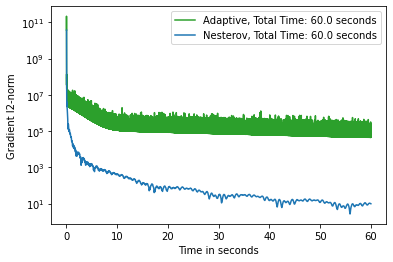

In [11]:
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Lin_adap_out.TimeTaken.iloc[-1],2)))
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Lin_nest_out.TimeTaken.iloc[-1],2)))
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.legend()
plt.ylabel('Gradient l2-norm')
plt.savefig("cali_nest_adap.png")

In [ ]:
Lin_line_out

In [121]:
H.gradNorm

346871.6969056245

In [119]:
pen = np.linalg.pinv(H.a)@H.b

In [120]:
np.allclose(H.x, pen)

False

In [115]:
MSE(H.b, H.a@pen)

0.6042095028861159

In [111]:
np.shape(H.b)

(20640,)

In [110]:
np.shape(np.linalg.pinv(H.a))

(8, 20640)

In [124]:
california()

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

## Breast Cancer

In [24]:
from sklearn.datasets import load_breast_cancer as cancer

In [26]:
feat_names = np.array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension'])

In [34]:
cancer(return_X_y=True)[0][0:3]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [33]:
cancer(return_X_y=True)[0][0:3,[0,1,2,3,4]]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01]])

In [35]:
feat_names[0:5]

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness'], dtype='<U23')

In [25]:
cancer()

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [37]:
print(tabulate(cancer(return_X_y=True)[0][0:3,[0,1,2,3,4]],tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrrr}
\hline
 17.99 & 10.38 & 122.80 & 1001.00 & 0.12 \\
 20.57 & 17.77 & 132.90 & 1326.00 & 0.08 \\
 19.69 & 21.25 & 130.00 & 1203.00 & 0.11 \\
\hline
\end{tabular}


In [15]:
np.shape(cancer(return_X_y=True)[0])

(569, 30)

In [49]:
H = Regression(1, 20)
H.importLogisticRegressionDataset(cancer)
H.Adaptive_Logistic_Reg("output/Log_Test_Adap_cancer1.csv")
H.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_cancer1.csv")
H.Vanilla_Logistic_Reg("output/Log_Test_Van_cancer1.csv")
H.Barzilai_Logistic_Reg("output/Log_Test_Baz_cancer1.csv")
H.Nesterov_Logistic_Reg("output/Log_Test_Nest_cancer1.csv")

<ipython-input-22-ca0eb55e731f>:347: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
<ipython-input-22-ca0eb55e731f>:438: RuntimeWarning: divide by zero encountered in double_scalars
  self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size


In [8]:
read_log("cancer")

In [16]:
print("Van final", Log_vanilla_out.head())
print("Adap final", Log_adap_out.head())
print("LS final", Log_line_out.head())
print("Baz final", Log_baz_out.head())
print("Nest final", Log_nest_out.head())

Van final    GradientNorms  TimeTaken  StepSizes  Accuracy
0     380.459202   0.212749   0.000613  0.631579
1     365.947736   0.213278   0.000613  0.631579
2     347.261531   0.213779   0.000613  0.631579
3     324.059476   0.214769   0.000613  0.631579
4     296.551404   0.215266   0.000613  0.631579
Adap final    GradientNorms  TimeTaken  StepSizes  Accuracy
0     380.459202   0.000991   0.104640  0.631579
1     483.751543   0.001487   0.104640  0.368421
2     483.751543   0.001983   0.023532  0.368421
3     483.743672   0.002974   0.026044  0.368421
4     317.714008   0.003967   0.037802  0.684211
LS final    GradientNorms  TimeTaken  StepSizes  Accuracy
0     380.459202   0.032735   0.002840  0.631579
1     257.667175   0.052773   0.003113  0.631579
2      90.190614   0.055750   0.044433  0.350877
3      59.027484   0.057239   0.003712  0.894737
4      26.799169   0.061206   0.058379  0.912281
Baz final    GradientNorms  TimeTaken  StepSizes  Accuracy
0     380.459202   0.024489  

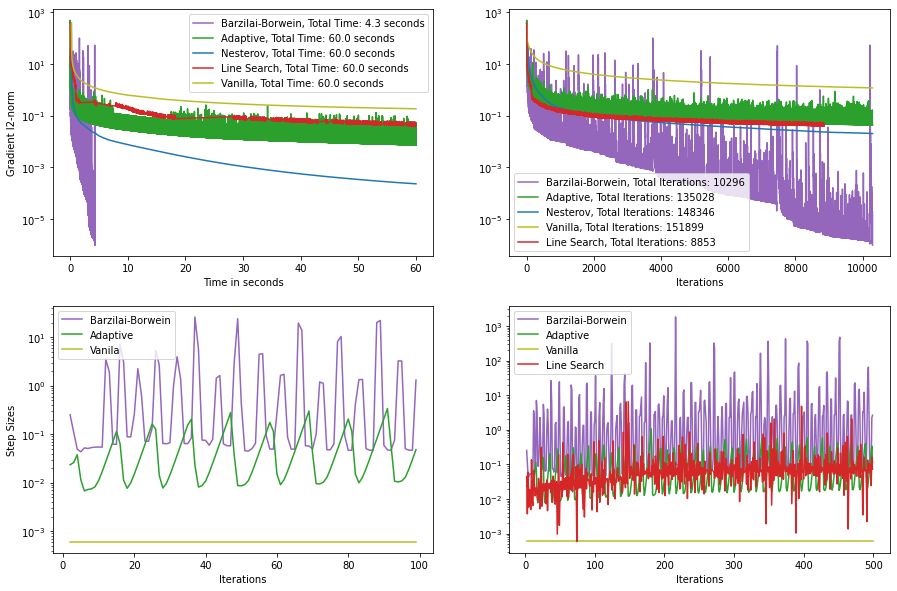

In [13]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Time: {} seconds'.format(round(Log_baz_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'tab:green', label = 'Adaptive, Total Time: {} seconds'.format(round(Log_adap_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_nest_out.TimeTaken, Log_nest_out.GradientNorms, c = 'tab:blue', label = 'Nesterov, Total Time: {} seconds'.format(round(Log_nest_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_line_out.TimeTaken, Log_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Time: {} seconds'.format(round(Log_line_out.TimeTaken.iloc[-1],2)))
ax1.plot(Log_vanilla_out.TimeTaken, Log_vanilla_out.GradientNorms, c = 'tab:olive', label = 'Vanilla, Total Time: {} seconds'.format(round(Log_vanilla_out.TimeTaken.iloc[-1],2)))
ax1.set_yscale('log')
ax1.set_xlabel('Time in seconds')
ax1.legend()
ax1.set_ylabel('Gradient l2-norm')
ax2.plot(ren(Log_baz_out.GradientNorms), Log_baz_out.GradientNorms, c = 'tab:purple', label = 'Barzilai-Borwein, Total Iterations: {}'.format(len(Log_baz_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_adap_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:green', label = 'Adaptive, Total Iterations: {}'.format(len(Log_adap_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_nest_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:blue', label = 'Nesterov, Total Iterations: {}'.format(len(Log_nest_out.GradientNorms)))
ax2.plot(ren(Log_baz_out.GradientNorms), Log_vanilla_out.GradientNorms[:len(Log_baz_out.GradientNorms)], c = 'tab:olive', label = 'Vanilla, Total Iterations: {}'.format(len(Log_vanilla_out.GradientNorms)))
ax2.plot(ren(Log_line_out.GradientNorms), Log_line_out.GradientNorms, c = 'tab:red', label = 'Line Search, Total Iterations: {}'.format(len(Log_line_out.GradientNorms)))
ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.legend()
ax3.plot(range(2,100), Log_baz_out.StepSizes[2:100],c = 'tab:purple', label = 'Barzilai-Borwein')
ax3.plot(range(2,100), Log_adap_out.StepSizes[2:100],c = 'tab:green', label = 'Adaptive')
ax3.plot(range(2,100), Log_vanilla_out.StepSizes[2:100],c = 'tab:olive', label = 'Vanila')
ax3.set_ylabel('Step Sizes')
ax3.set_xlabel('Iterations')
ax3.set_yscale('log')
ax3.legend()
ax4.plot(range(2,500), Log_baz_out.StepSizes[2:500],c = 'tab:purple', label = 'Barzilai-Borwein')
ax4.plot(range(2,500), Log_adap_out.StepSizes[2:500],c = 'tab:green', label = 'Adaptive')
ax4.plot(range(2,500), Log_vanilla_out.StepSizes[2:500],c = 'tab:olive', label = 'Vanilla')
ax4.plot(range(2,500), Log_line_out.StepSizes[2:500],c = 'tab:red', label = 'Line Search')
ax4.set_xlabel('Iterations')
ax4.set_yscale('log')
ax4.legend()
fig.savefig("log_reg_breast.png")

## Parkinsons (not working)

In [18]:
park = pd.read_csv("data/parkinsons.csv")
global Yy
v = np.array(park.status)
new_park = park.drop(axis = 1, columns = 'status')
global Xx
Xx = np.array(new_park).T[1:].T
Xx = Xx.astype(float)

In [17]:
Yy

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
def parki(return_X_y=True):
    return [Xx, Yy]

In [24]:
P = Regression(1e6, 30)
P.importLogisticRegressionDataset(parki)
P.Adaptive_Logistic_Reg("output/Log_Test_Adap_park.csv")
P.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_park.csv")
P.Vanilla_Logistic_Reg("output/Log_Test_Van_park.csv")
P.Barzilai_Logistic_Reg("output/Log_Test_Baz_park.csv")
P.Nesterov_Logistic_Reg("output/Log_Test_Nest_park.csv")

In [25]:
P.weights

array([0.12840265, 0.45599134, 0.76154421, 0.39526621, 0.23961996,
       0.7196764 , 0.80700685, 0.26916044, 0.80466195, 0.74616235,
       0.22401058, 0.74968002, 0.65950666, 0.61980398, 0.47119848,
       0.09589526, 0.3460457 , 0.52092942, 0.13718703, 0.28484105,
       0.56963912, 0.86251739, 0.50479754])

# Other stuff

Experimenting with numpy.linalg pinv and solve

In [64]:
T = Make_reg(n_samples=20, n_features=100)

In [65]:
numpyX = np.linalg.pinv(T[0]) @ T[1]

In [66]:
H = Regression(1e-10, 10)
H.customLinearRegressionDataset(T[0],T[1])
H.Adaptive_Linear_Reg("vanTest.csv")

In [67]:
np.allclose(T[0]@H.x, T[1])

True

In [68]:
np.allclose(T[0]@numpyX, T[1])

True

In [69]:
np.allclose(H.x, numpyX)

False

In [63]:
H.gradNorm

9.825951858952953e-11

Oscilation in Gradient values (last 200 iterations)

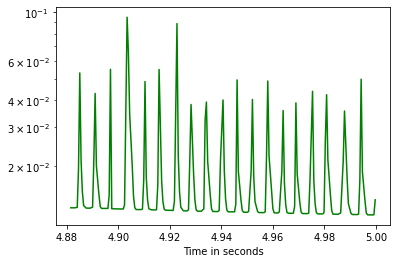

In [47]:
plt.plot(Lin_adap_out.TimeTaken.iloc[-200:-1], Lin_adap_out.GradientNorms.iloc[-200:-1], c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

non-monotone method

Oscilation in Function values (last 200 iterations)

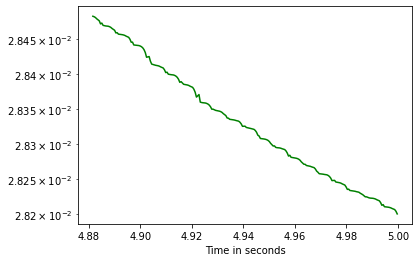

In [48]:
plt.plot(Lin_adap_out.TimeTaken.iloc[-200:-1], Lin_adap_out.FunctionValues.iloc[-200:-1], c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [50]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final        GradientNorms  TimeTaken  FunctionValues  Accuracy
40901       0.169685   4.999646        0.103069       0.9
40902       0.169682   4.999646        0.103069       0.9
40903       0.169680   4.999646        0.103068       0.9
40904       0.169678   4.999646        0.103067       0.9
40905       0.169675   5.000142        0.103067       0.9
Adap final        GradientNorms  TimeTaken  FunctionValues  Accuracy
25862       0.010151   4.999189        0.006087       0.9
25863       0.007823   4.999684        0.006087       0.9
25864       0.007117   4.999684        0.006087       0.9
25865       0.007040   4.999684        0.006087       0.9
25866       0.007039   5.000223        0.006086       0.9
LS final      GradientNorms  TimeTaken  FunctionValues  Accuracy
306       0.420536   1.953322        0.137341       0.9
307       0.370990   1.957789        0.137280       0.9
308       0.456602   1.966725        0.137101       0.9
309       0.365408   1.971178        0.137042     

In [51]:
Log_nest_out.Accuracy

0        0.009953
1        0.010453
2        0.010453
3        0.010947
4        0.010947
           ...   
39200    4.999750
39201    4.999750
39202    4.999750
39203    4.999750
39204    5.000245
Name: Accuracy, Length: 39205, dtype: float64

Check Lipschitz approx with SVD holds...

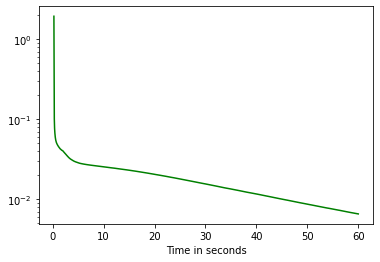

In [36]:
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.FunctionValues, c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()